In [ ]:
#Install Avalanche
!pip install git+https://github.com/ContinualAI/avalanche.git

  Cloning https://github.com/ContinualAI/avalanche.git to /tmp/pip-req-build-g2l36y8x
  Running command git clone --filter=blob:none --quiet https://github.com/ContinualAI/avalanche.git /tmp/pip-req-build-g2l36y8x
  Resolved https://github.com/ContinualAI/avalanche.git to commit 625e46d9203878ed51457f6d7cd8d4e9fb05d093
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.6/558.6 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [ ]:
import avalanche

In [ ]:
avalanche.__version__

'0.6.0a'

## Permuted MNIST using GEM

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD

from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training.supervised import GEM
from avalanche.evaluation.metrics import (
    forgetting_metrics,
    accuracy_metrics,
    bwt_metrics
)

from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin


In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Model
model = SimpleMLP(num_classes = 10)

In [ ]:
# CL Benchmark Creation
scenario = PermutedMNIST(n_experiences=5, seed = 1234)
train_stream = scenario.train_stream
test_stream = scenario.test_stream

In [ ]:
# Prepare for training & testing
optimizer = SGD(model.parameters(), lr = 0.001, momentum = 0.9)
criterion = CrossEntropyLoss()

In [ ]:
interactive_logger = InteractiveLogger()

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    loggers=[interactive_logger]
)

In [ ]:
# Choose a CL strategy
strategy = GEM(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    patterns_per_exp=100,
    train_mb_size=512,
    train_epochs=5,
    eval_mb_size=128,
    device=device,
    evaluator=eval_plugin
)

In [ ]:
# train and test loop - GEM
for i,train_task in enumerate(train_stream):
    print("--------------------------------------------------------------------")
    print("Starting training for {}".format(i))
    strategy.train(train_task)
    print("--------------------------------------------------------------------")
    print("Starting evaluation for {}".format(i))
    strategy.eval(test_stream)

--------------------------------------------------------------------
Starting training for 0
-- >> Start of training phase << --
100%|██████████| 118/118 [00:16<00:00,  7.02it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5786
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.7604
100%|██████████| 118/118 [00:17<00:00,  6.76it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8112
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8750
100%|██████████| 118/118 [00:17<00:00,  6.65it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8458
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9167
100%|██████████| 118/118 [00:16<00:00,  7.06it/s]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8623
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8854
100%|██████████| 118/118 [00:17<00:00,  6.81it/s]
Epoch 4 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8713
	Top1_Acc_MB/train_phase/train_strea

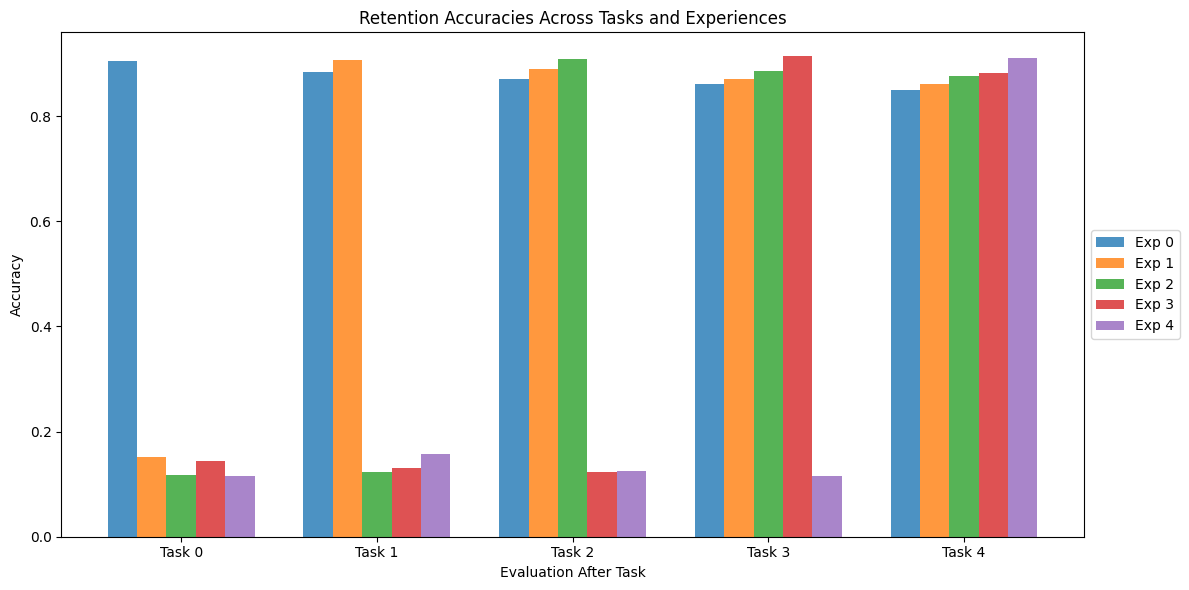

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Retention accuracies
accuracies = [
    [0.9047, 0.1512, 0.1175, 0.1441, 0.1151],  # After Task 0
    [0.8851, 0.9075, 0.1223, 0.1306, 0.1567],  # After Task 1
    [0.8718, 0.8892, 0.9088, 0.1239, 0.1256],  # After Task 2
    [0.8608, 0.8710, 0.8870, 0.9140, 0.1148],  # After Task 3
    [0.8494, 0.8615, 0.8769, 0.8831, 0.9115]   # After Task 4
]

# Prepare the data
accuracies = np.array(accuracies)
tasks = ['Task 0', 'Task 1', 'Task 2', 'Task 3', 'Task 4']
experiences = ['Exp 0', 'Exp 1', 'Exp 2', 'Exp 3', 'Exp 4']

# Create the plot
plt.figure(figsize=(12, 6))
bar_width = 0.15
index = np.arange(len(tasks))

# Plot bars for each experience
for i in range(len(experiences)):
    plt.bar(index + i*bar_width, accuracies[:, i],
            bar_width,
            label=experiences[i],
            alpha=0.8)

plt.xlabel('Evaluation After Task')
plt.ylabel('Accuracy')
plt.title('Retention Accuracies Across Tasks and Experiences')
plt.xticks(index + bar_width*2, tasks)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()